# Optimize the Eduati 2020 model using BNMPy optimizer

In the Eduati 2020 paper (doi: 10.15252/msb.209690, link: https://www.ncbi.nlm.nih.gov/pubmed/32073727), 
a logical model has been trained using drug response data to predict new treatment data using the CNOR-ODE tool.   
  
Here, we are trying to optimizie the model using the same data they provided, but with our PBN optimizer.

## Training data
Drug response data was obtained from GitHub repository: https://github.com/saezlab/ModelingMPS/tree/master/data/MIDAS_files

In [4]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append('./src')
from BNMPy import PBN, BMatrix, booleanNetwork, vis
from BNMPy.steady_state import SteadyStateCalculator
from Optimizer.experiment_data import ExperimentData
from Optimizer.parameter_optimizer import ParameterOptimizer
from Optimizer.model_compressor import compress_model
from Optimizer.sensitivity import sensitivity_analysis

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned.csv'

In [12]:
data_aspc1 = pd.read_csv('../data/Eduati2020_AsPC1.csv')
data_aspc1

,TR:AsPC1:CellLine,TR:EGFRi,TR:JAKi,TR:AktPi,TR:PDPK1i,TR:MEKi,TR:AktMi,TR:IKKsi,TR:PI3Ki,TR:TNF,TR:EGF,DA:ALL,DV:Cas3
0,1,0,0,0,0,0,0,0,0,0,1,0,0.000000
1,1,1,0,0,0,0,0,0,0,0,1,0,0.000000
2,1,0,1,0,0,0,0,0,0,0,1,0,0.000000
3,1,1,1,0,0,0,0,0,0,0,1,0,0.000000
4,1,0,0,1,1,0,0,0,0,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,1,0,0,1,1,0,0,0,0,1,1,30,0.317508
70,1,0,0,0,0,1,0,0,0,1,1,30,0.431260
71,1,0,0,0,0,0,1,0,0,1,1,30,0.579572
72,1,0,0,0,0,0,0,1,0,1,1,30,0.532916


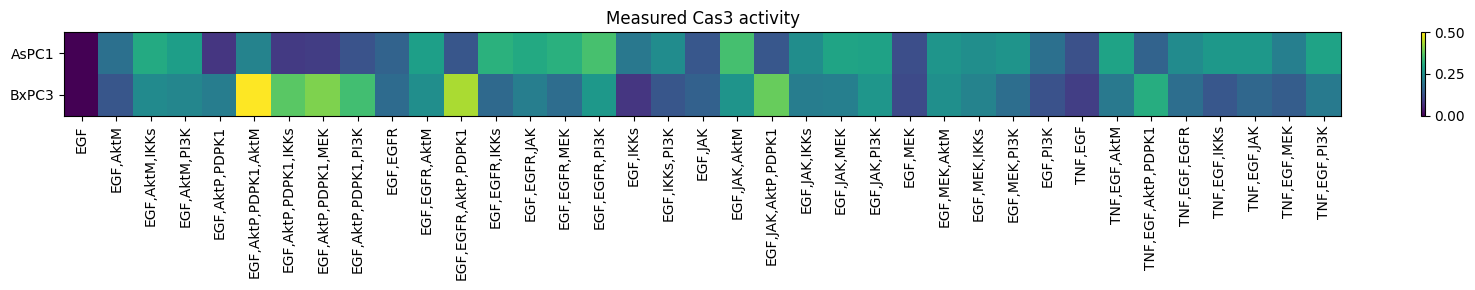

In [30]:
def row_to_condition(row, inhib_cols, stim_cols):
    """Return e.g.  'EGF, EGFRi'  or  'Untreated'."""
    inhibitors = [c.split(':')[-1][:-1]      
                  for c in inhib_cols if row[c] == 1]

    stimuli    = [c.split(':')[-1]    
                  for c in stim_cols if row[c] == 1]

    label = ",".join(stimuli + inhibitors)
    return label if label else "Untreated"

files = {
    "AsPC1": "../data/Eduati2020_AsPC1.csv",
    "BxPC3": "../data/Eduati2020_BxPC3.csv",
}

tidy = []
for cell, f in files.items():
    df = pd.read_csv(f,index_col=0)

    inhib_cols = [c for c in df if c.startswith('TR:') and c.endswith('i')]
    stim_cols  = [c for c in df if c.startswith('TR:') and not c.endswith('i')]

    df['condition'] = df.apply(row_to_condition,
                               axis=1,
                               inhib_cols=inhib_cols,
                               stim_cols=stim_cols)

    cas3 = (df.groupby('condition', sort=False)['DV:Cas3']
              .mean()
              .reset_index())
    cas3['cell_line'] = cell
    tidy.append(cas3)

tidy_df = (pd.concat(tidy)
           .pivot(index='cell_line', columns='condition', values='DV:Cas3'))
           
fig, ax = plt.subplots(figsize=(0.4*tidy_df.shape[1]+2, 3))
im = ax.imshow(tidy_df, aspect="auto")
ax.set_xticks(range(tidy_df.shape[1])); ax.set_xticklabels(tidy_df.columns, rotation=90)
ax.set_yticks(range(tidy_df.shape[0])); ax.set_yticklabels(tidy_df.index)
ax.set_title("Measured Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

The data was cleaned by changing names of genes to a standard HGNC symbol, and convert to a format that complys with our ExperimentData.

In [13]:
# Load it in BNMPy
data_aspc1 = ExperimentData.load_from_csv(data_aspc1_file)
data_aspc1

[{'id': 1,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': [],
  'inhibitors_efficacy': [],
  'measurements': {'CASP3': 0.0}},
 {'id': 2,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.317699657}},
 {'id': 3,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['JAK1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.270094786}},
 {'id': 4,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR', 'JAK1'],
  'inhibitors_efficacy': [1.0, 1.0],
  'measurements': {'CASP3': 0.607302371}},
 {'id': 5,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['AktP', 'PDPK1'],
  'inhibitors_efficacy': [1.0, 1.0],
  'measurements': {'CASP3': 0.159653529}},
 {'id': 6,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR', 'AktP', 'PDPK1'],
  'inhibitors_efficacy': [1.0, 1.0, 1.0],
  'measurements': {'CASP3': 

In [5]:
ExperimentData.get_experiment_summary(data_aspc1)

{'num_experiments': 37,
 'unique_stimuli': ['EGF', 'TNF'],
 'unique_inhibitors': ['AktP',
  'EGFR',
  'AktM',
  'JAK1',
  'MAP2K1',
  'IKBKB',
  'PIK3CA',
  'PDPK1'],
 'unique_measured_nodes': ['CASP3'],
 'value_ranges': {'CASP3': {'min': 0.0, 'max': 0.710918524}},
 'stimuli_efficacy_ranges': {'EGF': {'min': 1.0, 'max': 1.0},
  'TNF': {'min': 1.0, 'max': 1.0}},
 'inhibitors_efficacy_ranges': {'EGFR': {'min': 1.0, 'max': 1.0},
  'JAK1': {'min': 1.0, 'max': 1.0},
  'AktP': {'min': 1.0, 'max': 1.0},
  'PDPK1': {'min': 1.0, 'max': 1.0},
  'MAP2K1': {'min': 1.0, 'max': 1.0},
  'AktM': {'min': 1.0, 'max': 1.0},
  'IKBKB': {'min': 1.0, 'max': 1.0},
  'PIK3CA': {'min': 1.0, 'max': 1.0}}}

## Simulate the original model

Consider the mutations in the cell line.  
Mutation profiles for the cell lines are obtained from the GDSC database.

In [45]:
network = BMatrix.load_network_from_file(network_file)

equations = BMatrix.get_equations(file)
gene_dict = BMatrix.get_gene_dict(equations)
upstream_genes = BMatrix.get_upstream_genes(equations)
connectivity_matrix = BMatrix.get_connectivity_matrix(equations, upstream_genes, gene_dict)
truth_table = BMatrix.get_truth_table(equations, upstream_genes)
ngenes = len(equations)

# List of cell lines and their mutation profiles
## Obtained from the GDSC database
cell_profiles = {'AsPC1': 'RAS,p53',
                 'BxPC3': 'p53',
                 'Normal': ''}

# Dic file to specify how should the values of the genes be changed when mutated
file_mutations = '../input_files/mutations_Eduati2020.txt'
mutations_dict = BMatrix.get_mutation_dict(file_mutations)
print(f'mutations_dict: {mutations_dict}')

file_perturbations = '../input_files/perturbed_genes_Eduati2020.txt'
perturbations_dict = BMatrix.get_mutation_dict(file_perturbations)
print(f'perturbations_dict: {perturbations_dict}')

No initial state provided, using a random initial state
mutations_dict: {'p53': 0, 'RAS': 1, 'JNKK': 0}
perturbations_dict: {'EGFR': 0, 'JAK': 0, 'Akt': 0, 'PDPK1': 0, 'MEK': 0, 'IKKs': 0, 'PI3K': 0, 'EGF': 1, 'TNF': 1, 'AktP': 0, 'AktM': 0}


In [48]:
## no noise
n = 1000
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = booleanNetwork.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        network_traj = network.update(n)
        # network_traj = network.update_noise(0.05, 600)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [49]:
sim_df

,EGF,"EGF,AktM","EGF,AktM,IKKs","EGF,AktM,PI3K","EGF,AktP,PDPK1","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,IKKs","EGF,AktP,PDPK1,MEK","EGF,AktP,PDPK1,PI3K","EGF,EGFR",...,"EGF,MEK,PI3K","EGF,PI3K","TNF,EGF","TNF,EGF,AktM","TNF,EGF,AktP,PDPK1","TNF,EGF,EGFR","TNF,EGF,IKKs","TNF,EGF,JAK","TNF,EGF,MEK","TNF,EGF,PI3K"
AsPC1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BxPC3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Normal,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# with noise
n = 500000
noise = 0.05
scores = {}
sim_df = pd.DataFrame()
for cell_line in cell_profiles:
    print("cell line: ", cell_line)
    profile = cell_profiles[cell_line]
    print("mutation profile: ", profile)

    for condition in tidy_df.columns: 
        print('condition: ', condition)

        mutated_connectivity_matrix, x0 = BMatrix.get_knocking_genes(profile, mutations_dict, connectivity_matrix, gene_dict, condition, perturbations_dict)
        network = booleanNetwork.BooleanNetwork(ngenes, mutated_connectivity_matrix, truth_table, x0)
        # network_traj = network.update(n)
        network_traj = network.update_noise(noise, n)

        cal_range = network_traj[n//2:n]      # taking the second half of the simulation trajectory 
        average_array = np.mean(cal_range, axis=0)
        final_score = average_array[gene_dict['Cas3']]
        scores.update({condition: final_score})
    
    df_scores = pd.DataFrame(scores, index=[cell_line])
    sim_df = pd.concat([sim_df, df_scores])

cell line:  AsPC1
mutation profile:  RAS,p53
condition:  EGF
condition:  EGF,AktM
condition:  EGF,AktM,IKKs
condition:  EGF,AktM,PI3K
condition:  EGF,AktP,PDPK1
condition:  EGF,AktP,PDPK1,AktM
condition:  EGF,AktP,PDPK1,IKKs
condition:  EGF,AktP,PDPK1,MEK
condition:  EGF,AktP,PDPK1,PI3K
condition:  EGF,EGFR
condition:  EGF,EGFR,AktM
condition:  EGF,EGFR,AktP,PDPK1
condition:  EGF,EGFR,IKKs
condition:  EGF,EGFR,JAK
condition:  EGF,EGFR,MEK
condition:  EGF,EGFR,PI3K
condition:  EGF,IKKs
condition:  EGF,IKKs,PI3K
condition:  EGF,JAK
condition:  EGF,JAK,AktM
condition:  EGF,JAK,AktP,PDPK1
condition:  EGF,JAK,IKKs
condition:  EGF,JAK,MEK
condition:  EGF,JAK,PI3K
condition:  EGF,MEK
condition:  EGF,MEK,AktM
condition:  EGF,MEK,IKKs
condition:  EGF,MEK,PI3K
condition:  EGF,PI3K
condition:  TNF,EGF
condition:  TNF,EGF,AktM
condition:  TNF,EGF,AktP,PDPK1
condition:  TNF,EGF,EGFR
condition:  TNF,EGF,IKKs
condition:  TNF,EGF,JAK
condition:  TNF,EGF,MEK
condition:  TNF,EGF,PI3K
cell line:  BxPC3
m

In [57]:
sim_df

,EGF,"EGF,AktM","EGF,AktM,IKKs","EGF,AktM,PI3K","EGF,AktP,PDPK1","EGF,AktP,PDPK1,AktM","EGF,AktP,PDPK1,IKKs","EGF,AktP,PDPK1,MEK","EGF,AktP,PDPK1,PI3K","EGF,EGFR",...,"EGF,MEK,PI3K","EGF,PI3K","TNF,EGF","TNF,EGF,AktM","TNF,EGF,AktP,PDPK1","TNF,EGF,EGFR","TNF,EGF,IKKs","TNF,EGF,JAK","TNF,EGF,MEK","TNF,EGF,PI3K"
AsPC1,0.734044,0.74278,0.749984,0.750028,0.748776,0.756952,0.753588,0.754732,0.754368,0.745828,...,0.746132,0.742736,0.744008,0.745812,0.751776,0.748928,0.751356,0.746924,0.750688,0.753176
BxPC3,0.729192,0.73772,0.743628,0.741112,0.741784,0.750792,0.747292,0.748256,0.750464,0.736884,...,0.739948,0.737592,0.738036,0.745228,0.744328,0.743560,0.741684,0.742624,0.739788,0.746332
Normal,0.727068,0.73614,0.742456,0.739256,0.739620,0.747280,0.749392,0.747408,0.747532,0.736132,...,0.739748,0.735800,0.736692,0.742712,0.747828,0.744388,0.736560,0.743840,0.746540,0.739752


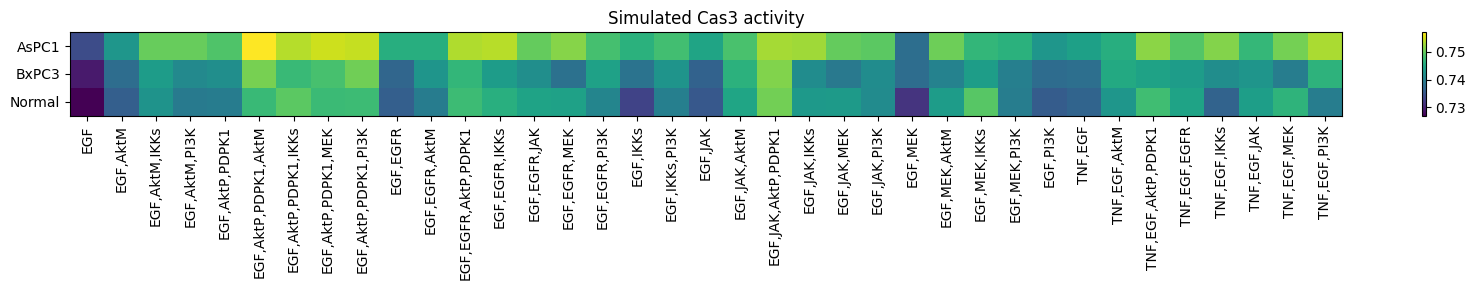

In [58]:
fig, ax = plt.subplots(figsize=(0.4*sim_df.shape[1]+2, 3))
im = ax.imshow(sim_df, aspect="auto")
ax.set_xticks(range(sim_df.shape[1])); ax.set_xticklabels(sim_df.columns, rotation=90)
ax.set_yticks(range(sim_df.shape[0])); ax.set_yticklabels(sim_df.index)
ax.set_title("Simulated Cas3 activity")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

## Compress the model

In [2]:
measured_nodes, perturbed_nodes = ExperimentData.extract_experiment_nodes(data_aspc1_file)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 10 perturbed nodes: {'EGF', 'IKBKB', 'AktP', 'PIK3CA', 'PDPK1', 'EGFR', 'MAP2K1', 'AktM', 'JAK1', 'TNF'}


In [3]:
network = BMatrix.load_network_from_file(network_file)

compressed_network, compression_info = compress_model(
    network,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

No initial state provided, using a random initial state
Model Compression Summary:
Removed 0 non-observable nodes
Removed 0 non-controllable nodes
Collapsed 0 linear paths

Total nodes removed/collapsed: 0
Final network size: 46 nodes
Network type: Boolean Network


In [4]:
vis.vis_compression_comparison(
    network,
    compressed_network, 
    compression_info,
    output_html="compression_Eduati2020.html",
    interactive=True,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

Network visualization saved to compression_Eduati2020.html


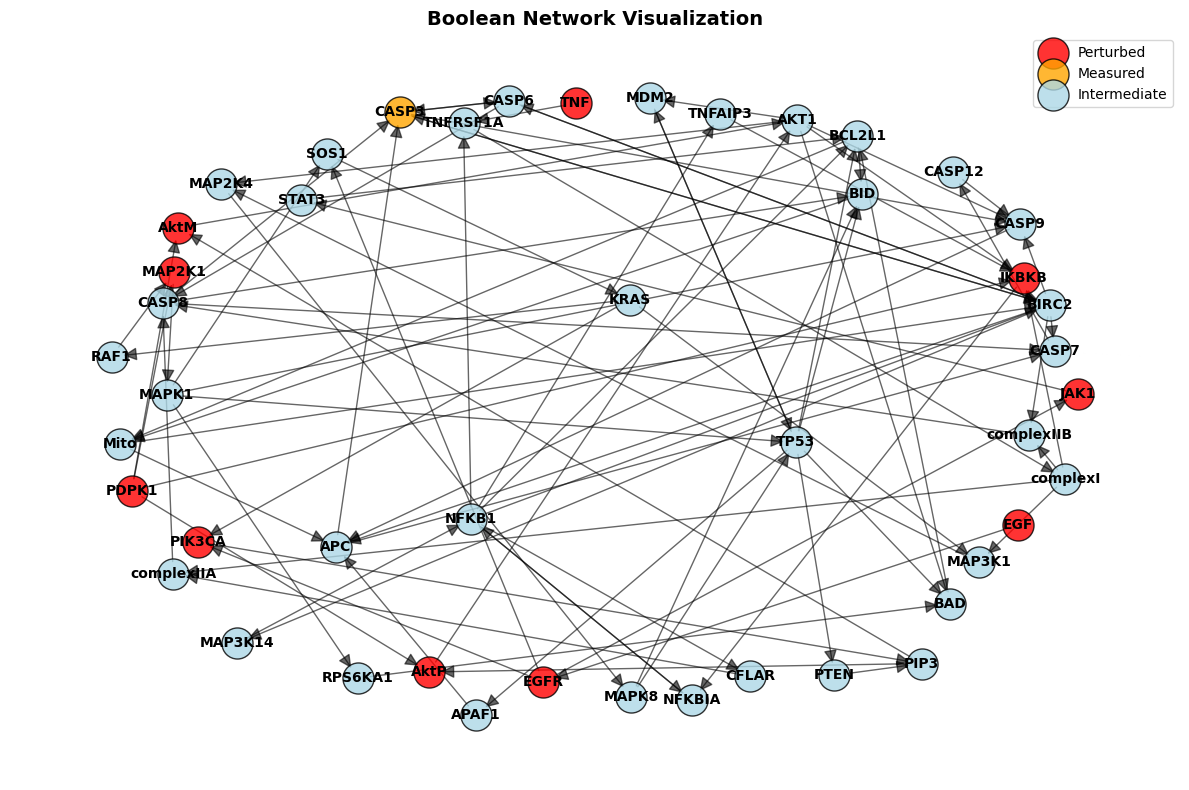

In [5]:
vis.vis_network(compressed_network,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

## Define alternative rule for PBN

We will just use self-loop as the alternative rules for now.  

E.g., for `TNFRSF1A = NFKB1 | TNF` in BN, its rule in PBN will be: 
   
`TNFRSF1A = NFKB1 | TNF, p`  
`TNFRSF1A = TNFRSF1A, 1-p`   
where p is the probability to be optimized. We will just put a 0.5 here as placeholder.

In [2]:
def BN2PBN(bn_string, prob=0.5):
    """
    Expand the boolean network to a PBN by adding a self-loop as alternative function
    prob: probability of the equations from the original BN

    Returns:
        pbn_string: string of the PBN
        nodes_to_optimize: list of nodes excludes input nodes
    """
    # Parse equations from BN
    bn_equations = {}
    for line in bn_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            bn_equations[target.strip()] = rule.strip()
    
    # Expand rules
    pbn_equations = []
    nodes_to_optimize = []

    for target in bn_equations.keys():
        if bn_equations[target] == target:
            # If its already a self-loop (e.g., a input node)
            pbn_equations.append(f"{target} = {bn_equations[target]}, 1")
        else:
            # Add the original rule with a prob
            pbn_equations.append(f"{target} = {bn_equations[target]}, {prob}")
            # Add the alternative rule
            pbn_equations.append(f"{target} = {target}, {round(1-prob,2)}")
            nodes_to_optimize.append(target)
    
    # remove equations with prob = 0
    pbn_equations = [eq for eq in pbn_equations if eq.split(',')[1] != ' 0']
    pbn_string = '\n'.join(pbn_equations)
    return pbn_string, nodes_to_optimize

with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, nodes_to_optimize = BN2PBN(bn_string, prob=0.5)
pbn = BMatrix.load_pbn_from_string(pbn_string)

print("PBN string:")
print(pbn_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.
PBN string:
AKT1 = AktM & AktP, 0.5
AKT1 = AKT1, 0.5
APAF1 = TP53, 0.5
APAF1 = APAF1, 0.5
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5
APC = APC, 0.5
AktM = PDPK1 & PIP3, 0.5
AktM = AktM, 0.5
AktP = PDPK1 & PIP3, 0.5
AktP = AktP, 0.5
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5
BAD = BAD, 0.5
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5
BCL2L1 = BCL2L1, 0.5
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5
BID = BID, 0.5
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5
BIRC2 = BIRC2, 0.5
CASP12 = CASP7, 0.5
CASP12 = CASP12, 0.5
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.5
CASP3 = CASP3, 0.5
CASP6 = ! BIRC2 | CASP3, 0.5
CASP6 = CASP6, 0.5
CASP7 = ! BIRC2 | CASP8 | APC, 0.5
CASP7 = CASP7, 0.5
CASP8 = complexIIB | complexIIA | CASP6, 0.5
CASP8 = CASP8, 0.5
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5
CASP9 = CASP9, 0.5
CFLAR = NFKB1, 0.5
CFLAR = CFLAR, 0.5
EGF = EGF, 1
EGFR = 

In [5]:
print(f"There are {len(nodes_to_optimize)} nodes to optimize:")
print(nodes_to_optimize)

There are 43 nodes to optimize:
['AKT1', 'APAF1', 'APC', 'AktM', 'AktP', 'BAD', 'BCL2L1', 'BID', 'BIRC2', 'CASP12', 'CASP3', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'CFLAR', 'EGFR', 'IKBKB', 'JAK1', 'KRAS', 'MAP2K1', 'MAP2K4', 'MAP3K1', 'MAP3K14', 'MAPK1', 'MAPK8', 'MDM2', 'Mito', 'NFKB1', 'NFKBIA', 'PIK3CA', 'PIP3', 'PTEN', 'RAF1', 'RPS6KA1', 'SOS1', 'STAT3', 'TNFAIP3', 'TNFRSF1A', 'TP53', 'complexI', 'complexIIA', 'complexIIB']


## Sensitivity analysis

In [5]:
# importlib.reload(sys.modules['Optimizer.sensitivity_analysis'])
from Optimizer.sensitivity_analysis import sensitivity_analysis
config = {
            'sensitivity_method': 'morris',  # 'morris', or 'sobol'
            'morris_trajectories': 200,       
            'sobol_samples': 512,                 
            'sobol_second_order': False,
            'steady_state': {
                'method': 'monte_carlo',
                'monte_carlo_params': {
                    'n_runs': 2,                
                    'n_steps': 10000,          
                    'p_noise': 0.05
                }
            }
        }
results = sensitivity_analysis(
    network=pbn, 
    experiments=data_aspc1_file, 
    config=config, 
    top_n=5, 
    verbose=True
)

PBN SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 46
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 42
  - Experiments: 37

Using MORRIS sensitivity analysis method
  - Parallel processing: Enabled (14 workers)

Morris analysis setup:
  - Parameters: 42
  - Trajectories: 200
  - Total evaluations: ~8600

Evaluating 8600 parameter sets in parallel (14 workers)...


100%|██████████| 57/57 [14:28:56<00:00, 914.67s/it]    


Identifying top 5 sensitive nodes...

Top 5 sensitive nodes (by average Mean |Effect|):
--------------------------------------------------
1. CASP8           - Avg: 0.0169, Max: 0.0169, Std: nan
2. CASP12          - Avg: 0.0150, Max: 0.0150, Std: nan
3. CASP6           - Avg: 0.0142, Max: 0.0142, Std: nan
4. CASP7           - Avg: 0.0118, Max: 0.0118, Std: nan
5. BIRC2           - Avg: 0.0072, Max: 0.0072, Std: nan

Sensitivity breakdown by measured node:
--------------------------------------------------

CASP8:
  -> CASP3     : 0.0169

CASP12:
  -> CASP3     : 0.0150

CASP6:
  -> CASP3     : 0.0142

Total analysis time: 52136.32 seconds


In [6]:
results

{'top_nodes': ['CASP8', 'CASP12', 'CASP6', 'CASP7', 'BIRC2'],
 'sensitivity_df':           node measured_node        mu   mu_star     sigma
 0         AKT1         CASP3 -0.000021  0.001898  0.002800
 1        APAF1         CASP3  0.002408  0.003517  0.004314
 2          APC         CASP3 -0.000053  0.003769  0.005653
 3         AktM         CASP3  0.000230  0.001857  0.002837
 4         AktP         CASP3  0.000311  0.001818  0.002544
 5          BAD         CASP3 -0.000878  0.003296  0.004756
 6       BCL2L1         CASP3 -0.001705  0.004273  0.006487
 7          BID         CASP3  0.000890  0.006490  0.009468
 8        BIRC2         CASP3 -0.005246  0.007190  0.009709
 9       CASP12         CASP3 -0.013763  0.014976  0.012223
 10       CASP6         CASP3  0.013569  0.014162  0.014846
 11       CASP7         CASP3 -0.011492  0.011766  0.008228
 12       CASP8         CASP3  0.013477  0.016938  0.020030
 13       CASP9         CASP3  0.001310  0.003077  0.004913
 14       CFLAR     

In [8]:
results['sensitivity_df'].to_csv("Eduati2020_sensitivity_morris_200_traj.csv")

## PBN steady state test

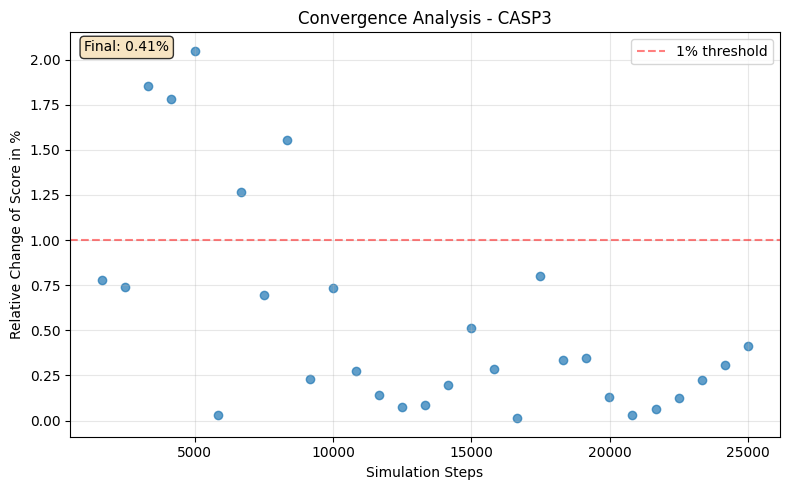

array([0.35562577, 0.60157594, 0.46666133, 0.52157914, 0.52025919,
       0.55085797, 0.85096596, 0.59637614, 0.82048718, 0.80300788,
       0.51981921, 0.56381745, 0.85528579, 0.8648854 , 0.92472301,
       0.57901684, 1.        , 0.9051238 , 0.83776649, 0.        ,
       0.10415583, 0.39486421, 0.52369905, 0.56613735, 0.38618455,
       0.40702372, 0.46402144, 0.60197592, 0.60185593, 0.59649614,
       0.63793448, 0.62861486, 0.85948562, 0.83660654, 0.6800528 ,
       0.40142394, 0.41058358, 0.68109276, 0.23195072, 0.26102956,
       0.49618015, 0.55517779, 0.61685533, 0.57457702, 0.58345666,
       0.58157674])

In [48]:
importlib.reload(sys.modules['BNMPy.steady_state'])
from BNMPy.steady_state import SteadyStateCalculator

calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGF'],inhibitors=['JAK1'])
calc.compute_steady_state(method='monte_carlo',n_runs=3,n_steps=50000,p_noise=0.05,analyze_convergence=True,output_node='CASP3')

In [ ]:
calc.compute_steady_state(method='tsmc',initial_nsteps=100,max_iterations=5000,freeze_self_loop=True)

In [ ]:
importlib.reload(sys.modules['Optimizer.parameter_optimizer'])
from Optimizer.parameter_optimizer import ParameterOptimizer
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 50,  # 20*number of parameters to optimize
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.5,
        'ftol_iter': 5
    },
    'steady_state': {
        # 'method': 'tsmc',
        #     'tsmc_params': {
        #         'epsilon': 0.05, # range of transition probability [Default=0.001]
        #         'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
        #         's': 0.85, # probability to acquire defined accuracy [Default=0.95]
        #         'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
        #         'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
        #         'max_iterations': 1000, # maximum convergence iterations [Default=5000]
        #         'freeze_self_loop': True # whether to treat self-loop as a fixed node
        #     },
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 2,
                'n_steps': 10000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 1, # threshold for accepting fit,
    'display_rules_every': 5  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

test_results = optimizer.test_steady_states()

## Run optimization for top node only
### for AsPC1

## Run optimizations for all nodes
### for AsPC1

In [30]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 50,  # 20*number of parameters to optimize
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.5,
        'ftol_iter': 5
    },
    'steady_state': {
        # 'method': 'tsmc',
        #     'tsmc_params': {
        #         'epsilon': 0.05, # range of transition probability [Default=0.001]
        #         'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
        #         's': 0.85, # probability to acquire defined accuracy [Default=0.95]
        #         'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
        #         'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
        #         'max_iterations': 1000, # maximum convergence iterations [Default=5000]
        #         'freeze_self_loop': True # whether to treat self-loop as a fixed node
        #     },
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 2,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 1, # threshold for accepting fit,
    'display_rules_every': 5  # Display optimized rules every n iterations (0 = disabled)
}

In [5]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-07-12 01:46:23,827 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 2

--- Attempt 1/2 ---
PSO early stopping enabled:
  - Function tolerance: 0.5
  - Tolerance iterations: 5


PSO Setup:
  - Particles: 50
  - Max iterations: 100
  - Problem dimensions: 86
  - Total function evaluations: 5000



pyswarms.single.global_best:   0%|          |0/100


Total SSE: 8.109637667697543

Total SSE: 7.998872819041096

Total SSE: 8.257693970214273

Total SSE: 7.98271555944163

Total SSE: 8.085509707759268

Total SSE: 8.024577981006413

Total SSE: 8.055697283506843

Total SSE: 6.5003231686589595

Total SSE: 8.152109781919206

Total SSE: 8.335946130195868

Total SSE: 7.996761808638444

Total SSE: 7.734308807894387

Total SSE: 8.194954091063533

Total SSE: 8.366145992614166

Total SSE: 8.156990814620654

Total SSE: 8.155183038780054

Total SSE: 8.200023126409775

Total SSE: 7.7427076790978955

Total SSE: 7.903721196414417

Total SSE: 8.083597473669416

Total SSE: 8.111001778196968

Total SSE: 8.434215657665174

Total SSE: 8.507479264493606

Total SSE: 8.08161122215137

Total SSE: 8.348726973511633

Total SSE: 8.262049848920519

Total SSE: 6.758597492250729

Total SSE: 7.895161182041371

Total SSE: 8.484283379922996

Total SSE: 8.050326013293386

Total SSE: 8.184005742968168

Total SSE: 7.8530117127769135

Total SSE: 8.139681960272977

Total SS

pyswarms.single.global_best:   1%|          |1/100, best_cost=5.44


Total SSE: 7.821727399208816
PSO Iteration 1: Current best SSE: 5.437115, Global best SSE: 5.437115

Total SSE: 8.644933186371023

Total SSE: 8.028218755397534

Total SSE: 8.341898060468974

Total SSE: 6.873619184059241

Total SSE: 8.42623652353616

Total SSE: 7.723375128088816

Total SSE: 8.28829938585112

Total SSE: 6.16344554506167

Total SSE: 7.797041893396331

Total SSE: 6.029228988029854

Total SSE: 7.539562003634529

Total SSE: 8.269284822514148

Total SSE: 6.907050372960143

Total SSE: 8.16603476351894

Total SSE: 8.025507126085916

Total SSE: 7.801645539505214

Total SSE: 7.732816909278409

Total SSE: 6.849360412984156

Total SSE: 7.555344736591193

Total SSE: 8.358158822439016

Total SSE: 7.945587212021833

Total SSE: 7.665290776751624

Total SSE: 6.490920247220819

Total SSE: 8.720890909531263

Total SSE: 8.177010531254075

Total SSE: 8.300550696197213

Total SSE: 7.94786742202571

Total SSE: 7.317597045267582

Total SSE: 8.730590862729768

Total SSE: 8.307374363608751

Tot

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=5.44


Total SSE: 8.287471969105948
PSO Iteration 2: Current best SSE: 6.029229, Global best SSE: 5.437115

Total SSE: 8.253629207221314

Total SSE: 8.270292096206703

Total SSE: 8.15135679128279

Total SSE: 7.858428728879663

Total SSE: 8.069532544826421

Total SSE: 7.948514989206699

Total SSE: 7.762670773978436

Total SSE: 7.536212972038694

Total SSE: 8.469498111149985

Total SSE: 7.6862079414982984

Total SSE: 8.246935256206038

Total SSE: 8.064766985166775

Total SSE: 7.979856832489938

Total SSE: 8.151231958134831

Total SSE: 8.305952464582054

Total SSE: 8.185126090445321

Total SSE: 8.171625915881068

Total SSE: 8.243013251245557

Total SSE: 8.078158044915439

Total SSE: 7.944395528581731

Total SSE: 8.356995484707747

Total SSE: 7.9508185658967925

Total SSE: 7.549478284569544

Total SSE: 6.826350511451257

Total SSE: 7.950160982137143

Total SSE: 7.642722283860424

Total SSE: 8.356741081472915

Total SSE: 7.950330943735798

Total SSE: 8.254691142026964

Total SSE: 8.10665765780275

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=5.34


Total SSE: 8.292751450606803
PSO Iteration 3: Current best SSE: 5.341467, Global best SSE: 5.341467

Total SSE: 7.84193156517065

Total SSE: 8.10442884862644

Total SSE: 7.242034954555675

Total SSE: 8.508516325223194

Total SSE: 7.302821400967608

Total SSE: 8.464886231271644

Total SSE: 7.615686936163885

Total SSE: 6.366145925810747

Total SSE: 7.95083674859254

Total SSE: 8.320529785896817

Total SSE: 5.820715238370262

Total SSE: 8.16084220102805

Total SSE: 7.952522968539841

Total SSE: 7.812767132854825

Total SSE: 7.444307083278831

Total SSE: 8.19135351993825

Total SSE: 7.630408317127785

Total SSE: 7.736618762376805

Total SSE: 8.236744601489287

Total SSE: 8.180180021463352

Total SSE: 8.108286432981785

Total SSE: 8.106067028968713

Total SSE: 7.81478594462824

Total SSE: 8.469309281598573

Total SSE: 8.021175358908637

Total SSE: 8.255524541465473

Total SSE: 8.196723069881442

Total SSE: 8.093387484292007

Total SSE: 8.221319739633152

Total SSE: 7.615620536267568

Tota

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=5.34


Total SSE: 7.981910918098127
PSO Iteration 4: Current best SSE: 5.386632, Global best SSE: 5.341467

Total SSE: 8.14735007210011

Total SSE: 8.013388113618158

Total SSE: 8.062641119948141

Total SSE: 7.723720370072146

Total SSE: 6.818954460502402

Total SSE: 8.207546369633803

Total SSE: 7.777774695171429

Total SSE: 6.977141858952543

Total SSE: 8.009052657398604

Total SSE: 8.042132875439291

Total SSE: 8.245700412209475

Total SSE: 8.15373325613299

Total SSE: 8.115501347872415

Total SSE: 6.928936087885688

Total SSE: 7.995296653155098

Total SSE: 8.123173584439748

Total SSE: 8.296098427004557

Total SSE: 7.330189840102547

Total SSE: 7.261549532127031

Total SSE: 8.10404114174941

Total SSE: 7.39571754192755

Total SSE: 8.025826537124614

Total SSE: 7.760370180315063

Total SSE: 7.933203483234903

Total SSE: 8.261776369015765

Total SSE: 7.950809964537577

Total SSE: 7.809422792042348

Total SSE: 7.741634740214785

Total SSE: 8.30770603277207

Total SSE: 8.0162533450467

Total

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=5.34


Total SSE: 7.64712752512634
PSO Iter 5: Best SSE: 5.341467 - Time: 7357.3s
  Current optimized rules:
    AKT1 = AktM & AktP, 0.6187
    AKT1 = AKT1, 0.3813
    APAF1 = TP53, 0.8717
    APAF1 = APAF1, 0.1283
    APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.9878
    APC = APC, 0.0122
    AktM = PDPK1 & PIP3, 0.4204
    AktM = AktM, 0.5796
    AktP = PDPK1 & PIP3, 0.4952
    AktP = AktP, 0.5048
    BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.0149
    BAD = BAD, 0.9851
    BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.8831
    BCL2L1 = BCL2L1, 0.1169
    BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.3422
    BID = BID, 0.6578
    BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.9974
    BIRC2 = BIRC2, 0.0026
    CASP12 = CASP7, 0.6230
    CASP12 = CASP12, 0.3770
    CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.0002
    CASP3 = CASP3, 0.9998
    CASP6 = ! BIRC2 | CASP3, 0.6244
    CASP6 = CASP6, 0.3756
    CASP7 = ! BIRC2 | CASP8 | APC, 0.5628
    CASP7 = CASP7, 0.4372
    CASP8 = complexIIB | complexIIA | CAS

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=5.34
2025-07-12 04:13:37,355 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.341467409454481, best pos: [5.34617548e-01 3.29450814e-01 7.40409260e-02 1.08955435e-02
 5.19872988e-01 6.41049345e-03 6.68695321e-01 9.21885652e-01
 9.54673410e-01 9.73272297e-01 1.44411544e-02 9.56772753e-01
 9.09154368e-01 1.20385158e-01 2.64727148e-01 5.08861382e-01
 8.83129684e-01 2.26442846e-03 4.57636661e-01 2.76971683e-01
 9.01547360e-05 5.55983102e-01 3.56315084e-01 2.14375484e-01
 1.96297283e-01 1.52497385e-01 8.06061901e-01 1.35838434e-01
 4.20220941e-01 1.17534797e-01 5.11130205e-01 7.12777059e-01
 9.50082680e-01 9.95472772e-01 5.55773975e-01 9.43285840e-01
 1.54625305e-01 8.37352283e-01 4.84918127e-01 4.55776831e-02
 6.12613937e-01 4.23906160e-01 3.02309862e-01 1.20844838e-01
 4.15351168e-01 5.05412096e-01 9.28695758e-01 9.89829236e-01
 3.80672492e-01 9.73699671e-01 1.66251098e-01 1.41419024e-01
 9.07343719e-


Total SSE: 6.6957341751784725
PSO Iteration 6: Current best SSE: 5.881496, Global best SSE: 5.341467
Total time: 8833.53 seconds
Optimization attempt 1 did not succeed: pyswarms optimization finished (early stopped). (SSE: 5.341467)
Optimized rules: ['AKT1 = AktM & AktP, 0.6187', 'AKT1 = AKT1, 0.3813', 'APAF1 = TP53, 0.8717', 'APAF1 = APAF1, 0.1283', 'APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.9878', 'APC = APC, 0.0122', 'AktM = PDPK1 & PIP3, 0.4204', 'AktM = AktM, 0.5796', 'AktP = PDPK1 & PIP3, 0.4952', 'AktP = AktP, 0.5048', 'BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.0149', 'BAD = BAD, 0.9851', 'BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.8831', 'BCL2L1 = BCL2L1, 0.1169', 'BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.3422', 'BID = BID, 0.6578', 'BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.9974', 'BIRC2 = BIRC2, 0.0026', 'CASP12 = CASP7, 0.6230', 'CASP12 = CASP12, 0.3770', 'CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.0002', 'CASP3 = CASP3, 0.9998', 'CASP6 = ! BIRC2 | CASP3, 0.6244', 'CASP6 = 

pyswarms.single.global_best:   0%|          |0/100


Total SSE: 7.917658506972387

Total SSE: 8.3579552744911

Total SSE: 8.041359724415507

Total SSE: 8.50772080685697

Total SSE: 8.447069188123509

Total SSE: 7.326567845172332

Total SSE: 8.040644564665563

Total SSE: 8.119527263267036

Total SSE: 7.2881801886663204

Total SSE: 7.82980306484179

Total SSE: 7.651215131801686

Total SSE: 5.527128965718099

Total SSE: 7.607617043418321

Total SSE: 8.4028348448208

Total SSE: 8.705077925382193

Total SSE: 8.054563782077565

Total SSE: 7.969184105979591

Total SSE: 8.080623854899054

Total SSE: 7.878185557393284

Total SSE: 7.785685911277573

Total SSE: 8.040328281009364

Total SSE: 8.355529510161334

Total SSE: 7.834482198072586

Total SSE: 7.883964471821321

Total SSE: 7.489392667921667

Total SSE: 8.11473545840597

Total SSE: 8.169965306055149

Total SSE: 5.5101534941359835

Total SSE: 5.633425815065386

Total SSE: 5.648891648518654

Total SSE: 7.743512699297017

Total SSE: 7.745418196535625

Total SSE: 7.941345113010637

Total SSE: 8.4

pyswarms.single.global_best:   1%|          |1/100, best_cost=5.51


Total SSE: 7.721720695397719
PSO Iteration 1: Current best SSE: 5.510153, Global best SSE: 5.510153

Total SSE: 8.059897006240906

Total SSE: 8.04189944950381

Total SSE: 8.34030419652144

Total SSE: 7.8198344797963335

Total SSE: 7.832757564938727

Total SSE: 7.430268259733737

Total SSE: 8.250790463201039

Total SSE: 7.774366664447584

Total SSE: 7.9843853171549375

Total SSE: 8.592503370604067

Total SSE: 8.292393265403586

Total SSE: 8.523876726722301

Total SSE: 8.194214019423615

Total SSE: 7.911178424411684

Total SSE: 6.454089815219857

Total SSE: 7.925805583013725

Total SSE: 7.594300710067353

Total SSE: 7.613179091783569

Total SSE: 8.292955829695742

Total SSE: 7.901417544537258

Total SSE: 7.68731886778414

Total SSE: 8.215287329716592

Total SSE: 7.1003567154180836

Total SSE: 8.063840952521373

Total SSE: 6.118508825075631

Total SSE: 7.936919210608351

Total SSE: 7.9505664941640655

Total SSE: 7.203567763818931

Total SSE: 7.868945223293549

Total SSE: 8.23574847804603

pyswarms.single.global_best:   2%|▏         |2/100, best_cost=5.51


Total SSE: 8.120573373399079
PSO Iteration 2: Current best SSE: 6.118509, Global best SSE: 5.510153

Total SSE: 8.223030557727244

Total SSE: 8.310050103996048

Total SSE: 7.961736964864568

Total SSE: 8.19832735825494

Total SSE: 8.307456079266428

Total SSE: 7.509162823647956

Total SSE: 8.115588456374217

Total SSE: 8.210421066052682

Total SSE: 7.95494272924996

Total SSE: 8.196974412697678

Total SSE: 7.466231175519047

Total SSE: 8.15968409364149

Total SSE: 8.731237660767043

Total SSE: 8.108601895850969

Total SSE: 8.172802188699766

Total SSE: 8.020981828405027

Total SSE: 7.991704972374581

Total SSE: 8.403236525513895

Total SSE: 7.773120281889789

Total SSE: 8.087259199110688

Total SSE: 8.101299891528631

Total SSE: 7.6880435351042395

Total SSE: 7.430143304149422

Total SSE: 8.342932918599645

Total SSE: 8.306944841523487

Total SSE: 8.145192717506124

Total SSE: 8.132455348577126

Total SSE: 7.642534812757204

Total SSE: 8.13252957892353

Total SSE: 8.344376902070728

T

pyswarms.single.global_best:   3%|▎         |3/100, best_cost=5.45


Total SSE: 8.201550887289088
PSO Iteration 3: Current best SSE: 5.450959, Global best SSE: 5.450959

Total SSE: 7.7765769199757395

Total SSE: 8.306605972859641

Total SSE: 7.706037008691831

Total SSE: 7.9394799762583546

Total SSE: 8.033541536152443

Total SSE: 7.36507133089589

Total SSE: 8.554612043105184

Total SSE: 8.099446501432162

Total SSE: 8.749331709440922

Total SSE: 7.98397252747404

Total SSE: 7.893504380931727

Total SSE: 8.425258149106117

Total SSE: 8.643149544979527

Total SSE: 7.770188936065594

Total SSE: 8.436737097526642

Total SSE: 8.627079578069605

Total SSE: 7.863388126956832

Total SSE: 8.080929494217173

Total SSE: 8.057255047500986

Total SSE: 8.057208828385333

Total SSE: 8.520298932141891

Total SSE: 7.291540956402657

Total SSE: 7.5047402385369635

Total SSE: 8.189845369858629

Total SSE: 8.172694464589542

Total SSE: 7.480553263118767

Total SSE: 7.992984188200149

Total SSE: 7.474459143443381

Total SSE: 8.102318394325522

Total SSE: 8.03591746794970

pyswarms.single.global_best:   4%|▍         |4/100, best_cost=5.45


Total SSE: 8.337795479122779
PSO Iteration 4: Current best SSE: 6.997798, Global best SSE: 5.450959

Total SSE: 7.873262353881457

Total SSE: 8.054601505452325

Total SSE: 7.600822316882616

Total SSE: 8.147492034572508

Total SSE: 8.161137892436292

Total SSE: 7.3085476749092875

Total SSE: 8.39858596556146

Total SSE: 8.145401857338364

Total SSE: 8.706857077686044

Total SSE: 8.159364024306628

Total SSE: 7.91362551417382

Total SSE: 8.042620155721863

Total SSE: 5.45881652492446

Total SSE: 7.783680314655875

Total SSE: 8.145129837658263

Total SSE: 8.108473535982405

Total SSE: 8.576637326173506

Total SSE: 8.384684369349477

Total SSE: 8.156710250851553

Total SSE: 8.031384729717104

Total SSE: 8.120612034942342

Total SSE: 8.191733446927957

Total SSE: 7.971585578293602

Total SSE: 7.989530933024398

Total SSE: 8.343873100890026

Total SSE: 8.165074821237386

Total SSE: 8.221753928700439

Total SSE: 5.759761923451835

Total SSE: 6.439987070741894

Total SSE: 7.862315586462868



pyswarms.single.global_best:   5%|▌         |5/100, best_cost=5.45


Total SSE: 7.596580683119134
PSO Iter 5: Best SSE: 5.450959 - Time: 7333.2s
  Current optimized rules:
    AKT1 = AktM & AktP, 0.9393
    AKT1 = AKT1, 0.0607
    APAF1 = TP53, 0.5094
    APAF1 = APAF1, 0.4906
    APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.6090
    APC = APC, 0.3910
    AktM = PDPK1 & PIP3, 0.2643
    AktM = AktM, 0.7357
    AktP = PDPK1 & PIP3, 0.5520
    AktP = AktP, 0.4480
    BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5655
    BAD = BAD, 0.4345
    BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.1435
    BCL2L1 = BCL2L1, 0.8565
    BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.0327
    BID = BID, 0.9673
    BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5153
    BIRC2 = BIRC2, 0.4847
    CASP12 = CASP7, 0.3554
    CASP12 = CASP12, 0.6446
    CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.0026
    CASP3 = CASP3, 0.9974
    CASP6 = ! BIRC2 | CASP3, 0.4983
    CASP6 = CASP6, 0.5017
    CASP7 = ! BIRC2 | CASP8 | APC, 0.5979
    CASP7 = CASP7, 0.4021
    CASP8 = complexIIB | complexIIA | CA

pyswarms.single.global_best:   5%|▌         |5/100, best_cost=5.45
2025-07-12 06:40:17,912 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.450959244578253, best pos: [0.7713072  0.04987523 0.06495626 0.06256214 0.99018126 0.63576372
 0.27776568 0.77306386 0.79309157 0.64354257 0.78585261 0.60392682
 0.11921366 0.71131964 0.01755085 0.51969025 0.67055816 0.63084781
 0.28866258 0.52351776 0.00176649 0.66765273 0.80519954 0.8107994
 0.85827296 0.5771097  0.21835058 0.51378127 0.15900411 0.60361306
 0.19226182 0.98837519 0.35242987 0.67713227 0.23041609 0.44490781
 0.46563    0.93763034 0.2877313  0.18140953 0.05392575 0.89996434
 0.02231754 0.40942128 0.94252008 0.85421945 0.26572855 0.84247768
 0.41070566 0.0349805  0.16929524 0.56898754 0.79414039 0.75953009
 0.71598953 0.61668721 0.06425739 0.60897475 0.57684797 0.12912243
 0.25909582 0.79498683 0.02125435 0.74138948 0.77026403 0.43384005
 0.49190867 0.4364211  0.13104944 0.68951789 0.74037036 0.09893893
 0.


Total SSE: 8.10546021920452
PSO Iteration 6: Current best SSE: 5.819611, Global best SSE: 5.450959
Total time: 8800.56 seconds
Optimization attempt 2 did not succeed: pyswarms optimization finished (early stopped). (SSE: 5.450959)
Optimized rules: ['AKT1 = AktM & AktP, 0.9393', 'AKT1 = AKT1, 0.0607', 'APAF1 = TP53, 0.5094', 'APAF1 = APAF1, 0.4906', 'APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.6090', 'APC = APC, 0.3910', 'AktM = PDPK1 & PIP3, 0.2643', 'AktM = AktM, 0.7357', 'AktP = PDPK1 & PIP3, 0.5520', 'AktP = AktP, 0.4480', 'BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5655', 'BAD = BAD, 0.4345', 'BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.1435', 'BCL2L1 = BCL2L1, 0.8565', 'BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.0327', 'BID = BID, 0.9673', 'BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5153', 'BIRC2 = BIRC2, 0.4847', 'CASP12 = CASP7, 0.3554', 'CASP12 = CASP12, 0.6446', 'CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.0026', 'CASP3 = CASP3, 0.9974', 'CASP6 = ! BIRC2 | CASP3, 0.4983', 'CASP6 = CA

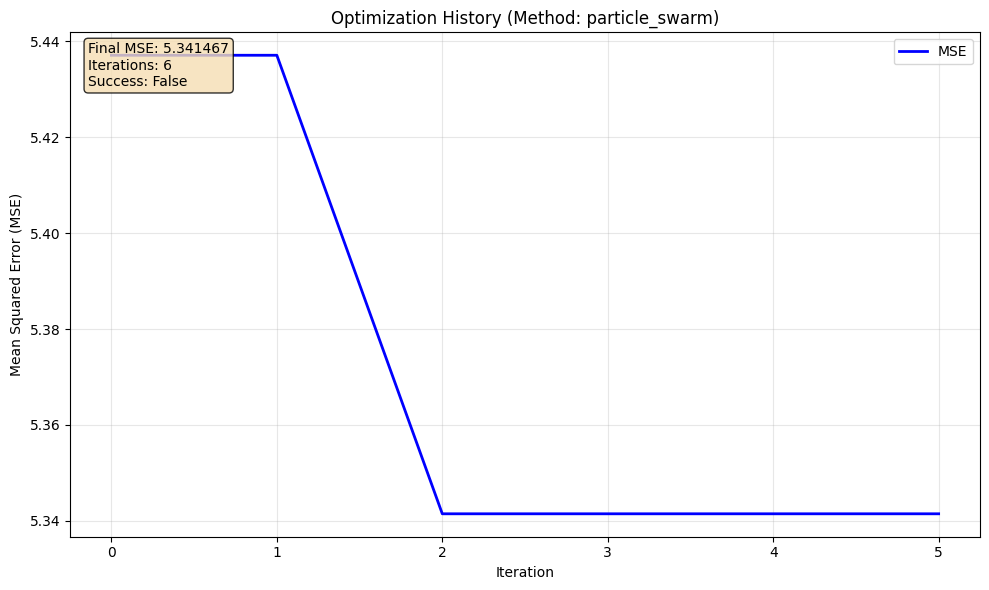

In [26]:
optimizer.plot_optimization_history(result)

In [4]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 15,
        'tol': 0.01, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': True  # Control early stopping
    },
    'steady_state': {
        # 'method': 'tsmc',
        #     'tsmc_params': {
        #         'epsilon': 0.001, # range of transition probability [Default=0.001]
        #         'r': 0.025, # range of accuracy (most sensitive) [Default=0.025]
        #         's': 0.95, # probability to acquire defined accuracy [Default=0.95]
        #         'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
        #         'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
        #         'max_iterations': 5000 # maximum convergence iterations [Default=5000]
        #     },
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 2,
                'n_steps': 5000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 5,  # An SSE below this is always a success (global)
    'display_rules_every': 5  # Display optimized rules every n iterations (0 = disabled)
    }

In [5]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)
result = optimizer.optimize(method='differential_evolution')


Running optimization using method: differential_evolution
Maximum attempts: 2

--- Attempt 1/2 ---
DE early stopping enabled:
  - Success threshold (MSE): 5
  - Relative tolerance: 0.01


Iteration 1: Current MSE: 0.145962, Best MSE so far: 0.145962, Convergence: 0.1077

DE early stopping: MSE below success threshold: 5
Total time: 80389.65 seconds

Successful optimization found in attempt 1
  - MSE: 0.144215

--- Optimization finished. Best MSE found: 0.144215 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.5714
AKT1 = AKT1, 0.4286
APAF1 = TP53, 0.5974
APAF1 = APAF1, 0.4026
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5433
APC = APC, 0.4567
AktM = PDPK1 & PIP3, 0.3577
AktM = AktM, 0.6423
AktP = PDPK1 & PIP3, 0.1431
AktP = AktP, 0.8569
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.3357
BAD = BAD, 0.6643
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5629
BCL2L1 = BCL2L1, 0.4371
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.3075
BID = BID, 0.6925
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.7207

### for BxPC3

In [ ]:
optimizer = ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

# Test on the optimized model
## Correlation between optimized and measured data

In [11]:
aspc1_pbn = optimizer.get_optimized_pbn(result)
measured_nodes, perturbed_nodes = ExperimentData.extract_experiment_nodes(data_aspc1_file)
vis.vis_network(aspc1_pbn,"AsPC1_optimized.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 10 perturbed nodes: {'PDPK1', 'JAK1', 'EGFR', 'AktM', 'IKBKB', 'PIK3CA', 'EGF', 'TNF', 'AktP', 'MAP2K1'}
Network visualization saved to AsPC1_optimized.html


In [27]:
importlib.reload(sys.modules['Optimizer.result_evaluation'])

from Optimizer.result_evaluation import evaluate_optimization_result
output_dir = "AsPC1_evaluation_results"
evaluator = evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    generate_plots=True,
    generate_report=True
)

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
  Experiment 8: 1 nodes simulated


KeyboardInterrupt: 